In [1]:
# N.B. Activate .env ?
import numpy as np
import pandas as pd
import os
#import pyarrow
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
#from transformers import BertTokenizer, BertModel, BertConfig
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from prep_input_data import get_vectorized_labelled_data


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print("Using device: " + device)

Using device: cpu


In [3]:
# Corpus and dictionary files to use
corpus_file = '../../data/democracy_reports_corpus_merged_040624.csv'
output_label_column = 'dimension0'
input_label_column = 'dimension0'


In [4]:
#df = pd.read_csv(corpus_file)
#print(df.columns)

In [5]:
#df_labelled = get_vectorized_labelled_data(corpus_file, column=input_label_column, group_by_idea=True)
df_labelled = get_vectorized_labelled_data(corpus_file, column=input_label_column, group_by_idea=False)
print(df_labelled)

/Users/reggie/Workspace/backdem/democracy-text-classification/notebooks/prep_input_data.py:84: DtypeWarning: Columns (4,5,6,8,9,10,12,13,14,17,18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(corpus_file, dtype={'year': str},comment='#')


                                                 sentence   country  year  \
0       "The president is directly elected for up to t...    turkey  2021   
1       "If no candidate wins an absolute majority of ...    turkey  2021   
2       "President Erdoğan has retained a dominant rol...    turkey  2021   
3       "A 2017 constitutional referendum instituted a...    turkey  2021   
4       "The snap June 2018 presidential election, whi...    turkey  2021   
...                                                   ...       ...   ...   
457907  virtual country visit to slovakia in the conte...  slovakia  2020   
457908  world economic forum (2013-2020), the global c...  slovakia  2020   
457909                annex ii: country visit to slovakia  slovakia  2020   
457910  the commission services held virtual meetings ...  slovakia  2020   
457911  * the commission also met the following organi...  slovakia  2020   

                             source          dimension1_r1     dimension2_r

In [6]:
# Get label names
labels = sorted(df_labelled[output_label_column].dropna().unique())
print(f'Labels: {labels}')

Labels: ['ambiguous', 'democracy', 'electoral', 'liberal', 'media', 'participatory']


<Axes: ylabel='dimension0'>

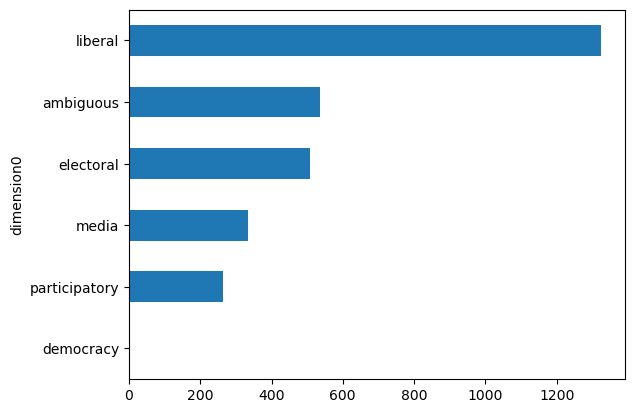

In [7]:
# Count the different classes to check how balanced they are
value_counts_dimension1 = df_labelled[output_label_column].value_counts()
value_counts_dimension1.sort_values().plot(kind="barh")

In [8]:
FRACTION_OF_DS_TO_USE = 1
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 1e-05
NO_LABELS = len(labels)
MAX_LOSS = 0.05

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


In [10]:
# Use part of the dataset
new_df = df_labelled.sample(frac=FRACTION_OF_DS_TO_USE, random_state=200)
# Display a sample of the dataset
new_df.sample(10)[['sentence', 'dimension0', 'label_vector']]

,sentence,dimension0,label_vector
332,"""In November, the ESMA rebuked the Federal Fin...",liberal,"[0, 0, 0, 1, 0, 0]"
416,"""Freedom of movement is legally protected and ...",liberal,"[0, 0, 0, 1, 0, 0]"
111,"""The government has also targeted LGBT+ events...",liberal,"[0, 0, 0, 1, 0, 0]"
455383,a number of reforms of the justice system were...,liberal,"[0, 0, 0, 1, 0, 0]"
457890,european network of councils for the judiciary...,ambiguous,"[1, 0, 0, 0, 0, 0]"
85405,"""Among mobile service providers, EE (owned by ...",ambiguous,"[1, 0, 0, 0, 0, 0]"
41411,"""He has also contributed to the Guardian, Wash...",ambiguous,"[1, 0, 0, 0, 0, 0]"
456009,council of europe: committee of ministers (201...,ambiguous,"[1, 0, 0, 0, 0, 0]"
456597,"in that regard, the council of europe had prev...",liberal,"[0, 0, 0, 1, 0, 0]"
63412,"""Buhovski, Anita, “ИЗГЛАСАН ЗАКОНОТ ЗА АНТИДИС...",ambiguous,"[1, 0, 0, 0, 0, 0]"


In [11]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.sentence
        self.targets = self.data.label_vector
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [12]:
train_size = 0.8
train_dataset=new_df.sample(frac=train_size,random_state=200)
test_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (2967, 24)
TRAIN Dataset: (2374, 24)
TEST Dataset: (593, 24)


<Axes: ylabel='dimension0'>

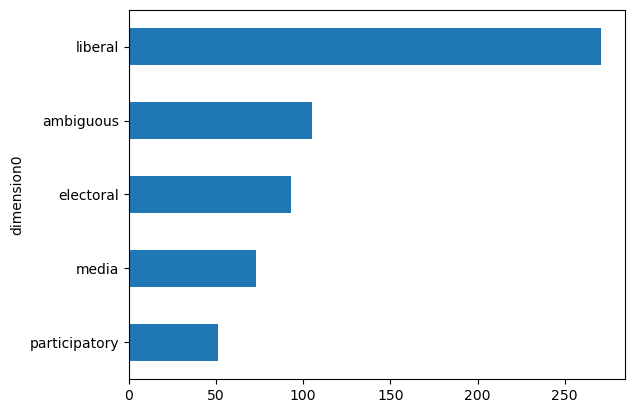

In [13]:
#value_counts_dimension1_train = train_dataset[output_label_column].value_counts()
#value_counts_dimension1_train.sort_values().plot(kind="barh")
value_counts_dimension1_test = test_dataset[output_label_column].value_counts()
value_counts_dimension1_test.sort_values().plot(kind="barh")

In [14]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [15]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class ROBERTAClass(torch.nn.Module):
    def __init__(self):
        super(ROBERTAClass, self).__init__()
        self.l1 = transformers.RobertaModel.from_pretrained('roberta-base')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, NO_LABELS)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = ROBERTAClass()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROBERTAClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [16]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [17]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [18]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        if loss.item() < MAX_LOSS:
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [ ]:
# Train
for epoch in range(EPOCHS):
    loss = train(epoch)
    print(f'Epoch {epoch} done')
    if loss.item() < MAX_LOSS:
        print(f'Loss minimized to below {MAX_LOSS}')
        break

Epoch: 0, Loss:  0.7053881287574768


In [18]:
from sklearn.metrics import confusion_matrix
def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [19]:
from sklearn.metrics import confusion_matrix
def validation_w_confusion():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    i_labels = []
    with torch.no_grad():
        for i, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            i_labels.append(test_dataset.iloc[i][output_label_column])
            #print(ids)
            #print(targets)
            #print(fin_targets)
            #print(fin_outputs)
            #break

    # Convert lists to numpy arrays
    fin_targets = np.array(fin_targets)
    fin_outputs = np.array(fin_outputs)
    
    # Get predicted labels by thresholding the predicted probabilities
    predicted_labels = (fin_outputs > 0.5).astype(int)
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(fin_targets.argmax(axis=1), predicted_labels.argmax(axis=1))
    return fin_outputs, fin_targets, conf_matrix, i_labels
    #return fin_outputs, fin_targets

In [20]:
# Validation
outputs, targets, confusion_matrix, f_labels = validation_w_confusion()
outputs_a = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs_a)
f1_score_micro = metrics.f1_score(targets, outputs_a, average='micro', zero_division=1)
f1_score_macro = metrics.f1_score(targets, outputs_a, average='macro', zero_division=1)
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
# Check https://stephenallwright.com/micro-vs-macro-f1-score/

Accuracy Score = 0.7317073170731707
F1 Score (Micro) = 0.7588270496708557
F1 Score (Macro) = 0.717606030445981


In [23]:
print(sorted(set(f_labels)))
print(confusion_matrix)

['ambiguous', 'electoral', 'liberal', 'media', 'participatory']
[[ 99  10  52  13   7]
 [ 11 183  19   1   1]
 [ 11  15 277   4   9]
 [  8   2   8  42   1]
 [  9   8  13   2  56]]


In [31]:
# Test our inputs
# Choose a sentence
#sample_row = new_df.sample()[['sentence', 'label_vector']]
sample_row = df_labelled.sample()[['sentence']]
sample_text = sample_row['sentence'].values[0]
print(sample_text)

"Under Polish law, abortion is permissible through the 12th week of pregnancy if a woman’s health or life is in danger or if the pregnancy is a result of a criminal act such as rape.


In [32]:
def get_dimension_from_prediction(v, l=labels):    
    index = v.index(max(v))
    if max(v) < 0.5:
        return "NoClass"
    else:
        return l[index]
    
# Encode the sentence
encoding = tokenizer.encode_plus(
  sample_text.lower(),
  add_special_tokens=True,
  max_length=MAX_LEN,
  padding='max_length',
  truncation=True,
  return_token_type_ids=True,
  return_tensors='pt'
)

input_ids = encoding["input_ids"]
mask = encoding["attention_mask"]
token_type_ids = encoding["token_type_ids"]
input_ids = input_ids.to(device, dtype=torch.long)
mask = mask.to(device, dtype=torch.long)
token_type_ids = token_type_ids.to(device, dtype=torch.long)

# Inference
output = torch.sigmoid(model(input_ids, mask, token_type_ids))
predictions = output[0].tolist()
for label, prediction in zip(labels, predictions):
    print(f"{label}: {prediction}")

ambiguous: 0.038549892604351044
electoral: 0.045237962156534195
liberal: 0.93044114112854
media: 0.02123861387372017
participatory: 0.013361451216042042


In [33]:
result_dim = get_dimension_from_prediction(predictions)
print(f'Statement "{sample_text}" was classified as: {result_dim}.')

Statement ""Under Polish law, abortion is permissible through the 12th week of pregnancy if a woman’s health or life is in danger or if the pregnancy is a result of a criminal act such as rape." was classified as: liberal.


In [27]:
# Save model
torch.save(model, 'ROBERTA_grouped_classifier_democracy.pth')
#torch.save(model.state_dict(), 'ROBERTA_classifier_democracy_state_dict.pth')